In [2]:
import pandas as pd

df = pd.read_csv('/Users/mohammednihal/Desktop/XAI/data/Global Superstore.csv',encoding='ISO-8859-1')
df = df.drop([col  for col in df.columns if 'Unnamed' in col], axis=1)

print(df.head())

print("DataFrame shape :" , df.shape)
print("\nDataFrame  head:")
print(df.head())
print("\nDataFrame columns:", df.columns.tolist())


   Row ID         Order ID  Order Date  ...    Profit Shipping Cost Order Priority
0   32298   CA-2012-124891  31-07-2012  ...  762.1845        933.57       Critical
1   26341    IN-2013-77878  05-02-2013  ... -288.7650        923.63       Critical
2   25330    IN-2013-71249  17-10-2013  ...  919.9710        915.49         Medium
3   13524  ES-2013-1579342  28-01-2013  ...  -96.5400        910.16         Medium
4   47221     SG-2013-4320  05-11-2013  ...  311.5200        903.04       Critical

[5 rows x 24 columns]
DataFrame shape : (51290, 24)

DataFrame  head:
   Row ID         Order ID  Order Date  ...    Profit Shipping Cost Order Priority
0   32298   CA-2012-124891  31-07-2012  ...  762.1845        933.57       Critical
1   26341    IN-2013-77878  05-02-2013  ... -288.7650        923.63       Critical
2   25330    IN-2013-71249  17-10-2013  ...  919.9710        915.49         Medium
3   13524  ES-2013-1579342  28-01-2013  ...  -96.5400        910.16         Medium
4   47221     SG

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta


def data_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df.copy()

    # Convert datetime columns
    datetime_columns = ['Order Date', 'Ship Date']
    for col in datetime_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, errors='coerce')

    # Remove exact duplicates
    df_clean = df_clean.drop_duplicates()

    # Remove potential duplicates based on Customer ID, Sales, and Profit
    df_clean = df_clean.drop_duplicates(subset=['Customer ID', 'Sales', 'Profit'], keep='first')

    # Fill missing numerical values with median
    numeric_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Fill missing categorical values with mode
    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if not df_clean[col].mode().empty:
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

    # Handle outliers using IQR
    def handle_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series.clip(lower=lower_bound, upper=upper_bound)

    numeric_cols_for_outliers = ['Sales', 'Profit', 'Quantity', 'Discount', 'Shipping Cost']
    for col in numeric_cols_for_outliers:
        if col in df_clean.columns:
            df_clean[col] = handle_outliers(df_clean[col])

    # Clip specific ranges
    df_clean['Profit'] = df_clean['Profit'].clip(lower=-1500, upper=10000)
    df_clean['Quantity'] = df_clean['Quantity'].clip(lower=1)
    df_clean['Discount'] = df_clean['Discount'].clip(0, 1)
    df_clean['Shipping Cost'] = df_clean['Shipping Cost'].clip(lower=0, upper=1000)

    # Calculate Unit Price safely
    discount_safe = (1 - df_clean['Discount']).replace(0, np.nan)
    df_clean['Unit_Price'] = (df_clean['Sales'] - df_clean['Shipping Cost'] - df_clean['Profit']) / (df_clean['Quantity'] * discount_safe)

    # Standardize categorical variables
    standardize_cols = ['Customer Name', 'City', 'State', 'Product Name', 'Country', 'Order Priority', 'Region', 'Market']
    for col in standardize_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].str.lower()

    # Remove any remaining NaNs
    df_clean = df_clean.dropna()

    # Sort by Order Date
    if 'Order Date' in df_clean.columns:
        df_clean = df_clean.sort_values(by='Order Date', ascending=True)

    df_clean.reset_index(drop=True, inplace=True)

    print(df_clean.head())

    # Optional: Save to CSV
    df_clean.to_csv('cleaned_data.csv', index=False)

    return df_clean


def Initial_col_drop(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_drop = [
        'Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name',
        'City', 'State', 'Country', 'Postal Code', 'Market', 'Region', 'Product ID',
        'Product Name', 'Year-Month', 'Sub-Category'
    ]
    return df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')


def main(df: pd.DataFrame):
    
    try:
        # Initial data overview
        print("\nInitial Data Overview:")
        print(f"Initial shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print("\nMissing Values Overview:")
        print(df.isnull().sum())

        # Cleaning data
        print("\nCleaning Data...")
        cleaned_df = data_cleaning(df)
        print(f"Data cleaned. Remaining rows: {len(cleaned_df)}")

        # Dropping unnecessary columns
        cleaned_df = Initial_col_drop(cleaned_df)
        print("Columns Dropped Successfully")
        print(f"Remaining columns: {cleaned_df.columns.tolist()}")

        return cleaned_df

    except Exception as e:
        print(f"Error in Data Cleaning Pipeline: {str(e)}")
        return None


if __name__ == "__main__":
    
    try:
        df = df  
        cleaned_df = main(df)

        if cleaned_df is not None:
            print("\nData Cleaning Pipeline Executed Successfully!")
        else:
            print("\nData Cleaning Pipeline Failed.")
    except FileNotFoundError:
        print("Data file not found. Please ensure 'your_data_file.csv' exists.")



Initial Data Overview:
Initial shape: (51290, 24)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country', 'Postal Code', 'Market', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority']

Missing Values Overview:
Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Cleaning Data...
  

In [4]:
print(cleaned_df['Category'].head(10))

0    Office Supplies
1    Office Supplies
2    Office Supplies
3    Office Supplies
4          Furniture
5    Office Supplies
6         Technology
7         Technology
8          Furniture
9    Office Supplies
Name: Category, dtype: object


In [5]:
column_name = 'Order Date'
print(cleaned_df[column_name].head())

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: Order Date, dtype: datetime64[ns]


In [6]:
import pandas as pd
import numpy as np

def check_missing_values(df, function_name):
    """Helper function to check and print missing values after feature creation."""
    print(f"Missing values in {function_name}: {df.isna().sum().sum()}")

def create_time_based_features(df):
    """Create time-based features with cyclic encoding."""
    if not pd.api.types.is_datetime64_any_dtype(df['Order Date']):
        df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

    df['Order Date'] = df['Order Date'].fillna(pd.Timestamp('2000-01-01'))  

    features_df = pd.DataFrame(index=df.index)

    # Cyclic encoding for Day_of_Week and Month
    features_df['Day_of_Week_sin'] = np.sin(2 * np.pi * df['Order Date'].dt.dayofweek / 7)
    features_df['Day_of_Week_cos'] = np.cos(2 * np.pi * df['Order Date'].dt.dayofweek / 7)
    features_df['Month_sin'] = np.sin(2 * np.pi * df['Order Date'].dt.month / 12)
    features_df['Month_cos'] = np.cos(2 * np.pi * df['Order Date'].dt.month / 12)

    # Add Is_Weekend (binary feature)
    features_df['Is_Weekend'] = df['Order Date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

    check_missing_values(features_df, "Time-Based Features")
    return features_df


def create_lag_features(df, features_df):
    """Create lag features and add to the existing features_df."""
    
    features_df['Sales_Lag_7'] = df['Sales'].shift(7)

    check_missing_values(features_df, "Lag Features")
    return features_df


def create_rolling_features(df, features_df):
    """Create rolling window statistics for each category."""
    categories = df['Category'].unique()

    for category in categories:
        cat_df = df[df['Category'] == category]

        rolling_sales = cat_df['Sales'].rolling(window=7, min_periods=7).mean()
        rolling_profit = cat_df['Profit'].rolling(window=7, min_periods=7).mean()

        features_df.loc[cat_df.index, f'Rolling_Sales_7_{category}'] = rolling_sales
        features_df.loc[cat_df.index, f'Rolling_Profit_7_{category}'] = rolling_profit

    for col in features_df.columns:
        if 'Rolling_Sales_7' in col:
            features_df[col] = features_df[col].ffill()  
        elif 'Rolling_Profit_7' in col:
            features_df[col] = features_df[col].bfill()  

    check_missing_values(features_df, "Rolling Features")
    return features_df


def create_cumulative_features(df, features_df):
    """Create cumulative features."""
    features_df['Cumulative_Sales'] = df.groupby('Category')['Sales'].cumsum()
    features_df['Cumulative_Profit'] = df.groupby('Category')['Profit'].cumsum()
    
    check_missing_values(features_df, "Cumulative Features")
    return features_df


def create_category_level_features(df, features_df):
    """Create category-level features."""
    category_sales_avg = df.groupby('Category')['Sales'].transform('mean')
    
    features_df['Sales_vs_Category_Avg'] = df['Sales'] - category_sales_avg
    
    check_missing_values(features_df, "Category-Level Features")
    return features_df


def create_growth_and_extra_features(df, features_df):
    """Create growth and extra features."""
    features_df['Category_Sales_Growth'] = df.groupby('Category')['Sales'].pct_change()
    features_df['Rolling_30_Sales'] = df.groupby('Category')['Sales'].rolling(30).mean().reset_index(level=0, drop=True)
    
    check_missing_values(features_df, "Growth and Extra Features")
    return features_df


def create_interaction_features(df, features_df):
    """Create interaction features between time-based and categorical/statistical features."""
    features_df['Weekend_Sales'] = features_df['Is_Weekend'] * df['Sales']
    
    
    check_missing_values(features_df, "Interaction Features")
    return features_df


def handle_missing_values(df, features_df):
    """Handle missing values created by lagged features, rolling statistics, and growth/extra features."""
    # Dynamically identify columns with NaN values
    nan_columns = features_df.columns[features_df.isna().any()].tolist()
    
    # Fill NaN values based on column type or name
    for col in nan_columns:
        if 'Rolling' in col:  # Handle rolling features
            if 'Sales' in col:
                features_df[col] = features_df[col].fillna(df['Sales'].mean())
            elif 'Profit' in col:
                features_df[col] = features_df[col].fillna(df['Profit'].mean())
            else:
                features_df[col] = features_df[col].fillna(0)  # Default to 0 for other rolling features
        elif 'Lag' in col:  # Handle lag features
            features_df[col] = features_df[col].fillna(df['Sales'].mean())
        elif 'Growth' in col:  # Handle growth features
            features_df[col] = features_df[col].fillna(0)  # Default to 0 for growth features
        else:  # Handle all other columns
            features_df[col] = features_df[col].fillna(0)  # Default to 0 for unknown columns
    
    # Re-check for missing values after handling
    check_missing_values(features_df, "Missing Value Handling")
    
    return features_df


# Call the function to create time-based features
features_df = create_time_based_features(cleaned_df)

# Call the function to create lag features and add them to the same features_df
features_df = create_lag_features(cleaned_df, features_df)

# Call the function to create rolling features and add them to the same features_df
features_df = create_rolling_features(cleaned_df, features_df)

# Call the function to create cumulative features and add them to the same features_df
features_df = create_cumulative_features(cleaned_df, features_df)

# Call the function to create category-level features and add them to the same features_df
features_df = create_category_level_features(cleaned_df, features_df)

# Call the function to create growth and extra features and add them to the same features_df
features_df = create_growth_and_extra_features(cleaned_df, features_df)

# Call the function to create interaction features and add them to the same features_df
features_df = create_interaction_features(cleaned_df, features_df)

# Call the function to handle missing values
features_df = handle_missing_values(cleaned_df, features_df)

# Print the first few rows to check the result
print(features_df.head(10))
print(features_df.columns.tolist())
print(cleaned_df.columns.tolist())

# Combine the original dataframe with the engineered features
df_combined = pd.concat([cleaned_df, features_df], axis=1)

# Optionally, reset the index if needed
df_combined.reset_index(drop=True, inplace=True)

print(f"Total missing values in the combined dataset: {df_combined.isna().sum().sum()}")
print(f"Shape of the combined dataset: {df_combined.shape}")

Missing values in Time-Based Features: 0
Missing values in Lag Features: 7
Missing values in Rolling Features: 93
Missing values in Cumulative Features: 93
Missing values in Category-Level Features: 93
Missing values in Growth and Extra Features: 183
Missing values in Interaction Features: 183
Missing values in Missing Value Handling: 0
   Day_of_Week_sin  Day_of_Week_cos  ...  Rolling_30_Sales  Weekend_Sales
0        -0.974928        -0.222521  ...        172.398334         66.120
1        -0.974928        -0.222521  ...        172.398334        120.366
2        -0.974928        -0.222521  ...        172.398334         44.865
3        -0.974928        -0.222521  ...        172.398334         55.242
4        -0.974928        -0.222521  ...        172.398334        113.670
5        -0.974928        -0.222521  ...        172.398334        408.300
6        -0.781831         0.623490  ...        172.398334        314.220
7         0.000000         1.000000  ...        172.398334          0

In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def encode_data(df_combined):
    # Initialize the OneHotEncoder
    onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)

    # Initialize the LabelEncoder for the 'Segment' column
    label_encoder = LabelEncoder()

    # Apply One-Hot Encoding to the 'Category' column if it exists
    if 'Category' in df_combined.columns:
        category_encoder = OneHotEncoder(sparse_output=False)
        encoded_category = category_encoder.fit_transform(df_combined[['Category']])
        encoded_category_df = pd.DataFrame(encoded_category, columns=category_encoder.get_feature_names_out(['Category']))
        
        # Drop the original 'Category' column after encoding
        df_combined.drop(columns=['Category'], inplace=True)
        
        # Concatenate the encoded 'Category' columns back to the dataframe
        df_combined = pd.concat([df_combined, encoded_category_df], axis=1)

    # Label Encode 'Segment' column
    if 'Segment' in df_combined.columns:
        df_combined['Segment'] = label_encoder.fit_transform(df_combined['Segment'])

    # Apply Priority Mapping to 'Order Priority' column
    if 'Order Priority' in df_combined.columns:
        priority_mapping = {"low": 1, "medium": 2, "high": 3, "critical": 4}
        df_combined['Order Priority_Code'] = df_combined['Order Priority'].map(priority_mapping)
        df_combined.drop('Order Priority', axis=1, inplace=True)  # Drop original Order Priority column in place

    # Return the newly encoded DataFrame
    return df_combined

# Example usage
# Load your dataframe here
# df_combined = pd.read_csv('your_data.csv')
df_combined = encode_data(df_combined)
print(df_combined.head())

  Order Date  Segment  ...  Category_Technology  Order Priority_Code
0 2011-01-01        0  ...                  0.0                    3
1 2011-01-01        0  ...                  0.0                    2
2 2011-01-01        2  ...                  0.0                    3
3 2011-01-01        0  ...                  0.0                    2
4 2011-01-01        0  ...                  0.0                    2

[5 rows x 30 columns]


In [12]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler

df_processed = df_combined.copy()

Total_null = df_processed.isnull().sum().sum()
print("The total number of Null in the data :" , Total_null)

order_date_stored = df_processed['Order Date'].copy()
feature_name_stored = df_processed.columns.tolist()
df_processed = df_processed.drop(columns=['Order Date'])

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_processed), columns = df_processed.columns, index = df_processed.index)
print(df_normalized.head())


time_steps = 30

def create_sequence(data, time_steps = 30):
    X, y = [],[]
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps].values)
        y.append(data.iloc[i+time_steps].values[0])
    return np.array(X), np.array(y)

X,y = create_sequence(df_normalized, time_steps)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


The total number of Null in the data : 0
   Segment     Sales  ...  Category_Technology  Order Priority_Code
0      0.0  0.113013  ...                  0.0             0.666667
1      0.0  0.206358  ...                  0.0             0.333333
2      1.0  0.076438  ...                  0.0             0.666667
3      0.0  0.094295  ...                  0.0             0.333333
4      0.0  0.194836  ...                  0.0             0.333333

[5 rows x 29 columns]
(40971, 30, 29)
(10243, 30, 29)
(40971,)
(10243,)


x_test: (10243, 600)
x_train (40971, 600)
y_train (40971, 1)
y_test (10243, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

class SalesForecaster:
    def __init__(self, sequence_length, n_features, attention_size=32):
        """Initialize the Sales Forecaster model"""
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.attention_size = attention_size
        self.model = None
        self.training_history = None
        self.metrics_history = []
        
    def build_model(self):
        """Create an optimized attention-based LSTM model architecture with reduced overfitting"""
        inputs = layers.Input(shape=(self.sequence_length, self.n_features))
        
        # LSTM layer with regularization
        x = layers.LSTM(64, return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01),
                        recurrent_regularizer=regularizers.l2(0.01),
                        dropout=0.5,
                        recurrent_dropout=0.3)(inputs)
        x = layers.BatchNormalization()(x)
        
        # Attention mechanism
        attention = layers.Attention()([x, x])
        attention = layers.Dropout(0.4)(attention)
        
        # Global Average Pooling to reduce complexity
        x = layers.GlobalAveragePooling1D()(attention)
        
        # Dense layers with regularization
        x = layers.Dense(32, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        
        x = layers.Dense(16, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # Output layer
        outputs = layers.Dense(1, activation='linear')(x)
        
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
                          loss='huber',  # Robust to outliers
                          metrics=['mae', 'mse'])
        return self
    
    def preprocess_data(self, X, y):
        """Robust data preprocessing with outlier handling"""
        # Robust scaling for input features
        X_median = np.median(X, axis=(0, 1), keepdims=True)
        X_iqr = np.percentile(X, 75, axis=(0, 1), keepdims=True) - np.percentile(X, 25, axis=(0, 1), keepdims=True)
        X_scaled = (X - X_median) / (X_iqr + 1e-8)
        X_scaled = np.clip(X_scaled, -5, 5)  # Clip outliers
        
        # Log-transform the target variable
        y_log = np.log1p(np.maximum(y, 0))
        y_median = np.median(y_log)
        y_iqr = np.percentile(y_log, 75) - np.percentile(y_log, 25)
        y_scaled = (y_log - y_median) / (y_iqr + 1e-8)
        y_scaled = np.clip(y_scaled, -5, 5)
        
        return X_scaled, y_scaled, (y_median, y_iqr)
    
    def train_with_cv(self, X, y, n_splits=5, epochs=100, batch_size=32):
        """Train model with time series cross-validation"""
        tscv = TimeSeriesSplit(n_splits=n_splits)
        self.metrics_history = []
        
        # Preprocess data
        X_scaled, y_scaled, y_stats = self.preprocess_data(X, y)
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
            print(f"\nFold {fold + 1}/{n_splits}")
            
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]
            
            # Build fresh model for each fold
            self.build_model()
            
            # Callbacks for early stopping and learning rate scheduling
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=15,
                    restore_best_weights=True,
                    min_delta=0.001
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=8,
                    min_lr=1e-6
                )
            ]
            
            # Train model
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )
            
            # Evaluate model
            y_val_pred = self.model.predict(X_val)
            y_val_pred = np.expm1(y_val_pred * y_stats[1] + y_stats[0])
            y_val_orig = np.expm1(y_val * y_stats[1] + y_stats[0])
            
            metrics = {
                'MSE': mean_squared_error(y_val_orig, y_val_pred),
                'RMSE': np.sqrt(mean_squared_error(y_val_orig, y_val_pred)),
                'MAE': mean_absolute_error(y_val_orig, y_val_pred),
                'R2': r2_score(y_val_orig, y_val_pred),
                'MAPE': np.mean(np.abs((y_val_orig - y_val_pred.flatten()) / (y_val_orig + 1e-8))) * 100
            }
            
            self.metrics_history.append(metrics)
            self._plot_training_history(history, fold)
            
            # Save best model
            if fold == 0:
                self.model.save(f'best_model_{datetime.now().strftime("%Y%m%d")}.keras')
                self.training_history = history.history
        
        return self
    
    def _plot_training_history(self, history, fold):
        """Plot training and validation metrics"""
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {fold+1} - Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title(f'Fold {fold+1} - MAE')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'training_history_fold_{fold+1}.png')
        plt.close()
    
    def generate_performance_report(self):
        """Generate performance report"""
        metrics_df = pd.DataFrame(self.metrics_history)
        print("\nPerformance Metrics:")
        print(metrics_df.mean())
        return metrics_df

def create_sequences(data, sequence_length):
    """Convert 2D data into 3D sequences"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])
        y.append(data[i+sequence_length, -1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def main():
    # Load data
    data = pd.read_csv('/Users/mohammednihal/Desktop/XAI/model/X_train.csv')
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    data_values = data.values
    
    # Create sequences
    sequence_length = 10
    n_features = data_values.shape[1] - 1
    X_train, y_train = create_sequences(data_values, sequence_length)
    
    # Train model
    forecaster = SalesForecaster(sequence_length=sequence_length, n_features=n_features)
    forecaster.train_with_cv(X_train, y_train, epochs=100, batch_size=32)
    
    # Generate report
    metrics_df = forecaster.generate_performance_report()
    return forecaster, metrics_df

if __name__ == "__main__":
    forecaster, metrics_df = main()


Fold 1/5
Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 4.7569 - mae: 1.0141 - mse: 1.7679 - val_loss: 2.0189 - val_mae: 0.2909 - val_mse: 0.1434 - learning_rate: 0.0010
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7028 - mae: 0.5215 - mse: 0.4702 - val_loss: 0.6840 - val_mae: 0.2117 - val_mse: 0.0967 - learning_rate: 0.0010
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6327 - mae: 0.3694 - mse: 0.2496 - val_loss: 0.3253 - val_mae: 0.1874 - val_mse: 0.0988 - learning_rate: 0.0010
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3200 - mae: 0.2964 - mse: 0.1684 - val_loss: 0.1888 - val_mae: 0.1861 - val_mse: 0.0823 - learning_rate: 0.0010
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1922 - mae: 0.2606 - mse: 0.1354 - val_loss: 0.1229 - val_mae: 0.1829 - val_mse: 0.0896 - learning_rate: 0.0010
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1327 - mae: 0.2458 - mse: 0.1240 - val_loss: 0

Model loaded from: /Users/mohammednihal/Desktop/XAI/model/best_model_20250218.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== Backtesting Results ===
   MSE:     0.0068
  RMSE:     0.0824
   MAE:     0.0424
    R2:     0.9202


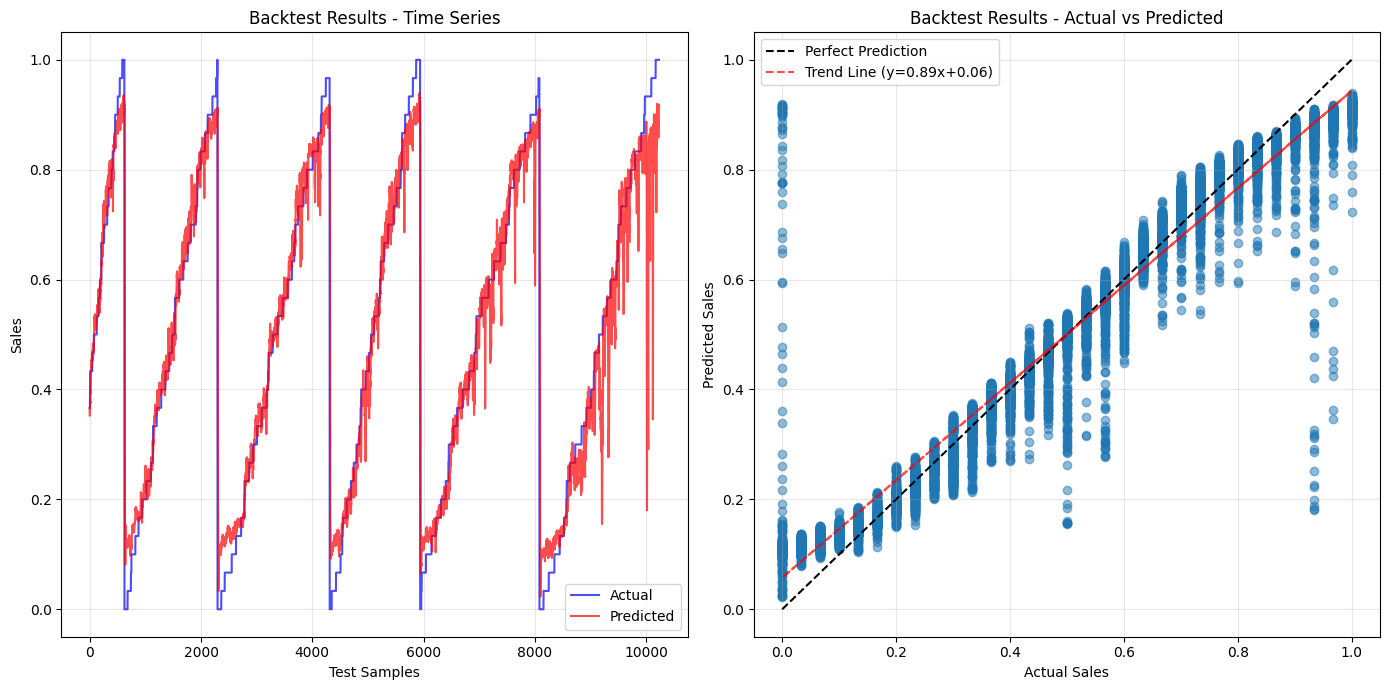

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_test_data(X_test_path, y_test_path):
    """Load and preprocess test data"""
    X_test = pd.read_csv(X_test_path)
    y_test = pd.read_csv(y_test_path)
    
    # Clean data
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    y_test = y_test.replace([np.inf, -np.inf], np.nan)
    
    # Drop any rows with NaN values
    X_test = X_test.dropna()
    y_test = y_test.dropna()
    
    # Ensure X_test and y_test have the same number of samples
    common_index = X_test.index.intersection(y_test.index)
    X_test = X_test.loc[common_index]
    y_test = y_test.loc[common_index]
    
    return X_test, y_test

def prepare_test_sequences(X_test, y_test, sequence_length):
    """Prepare sequences for testing"""
    # Ensure we only use the feature columns (exclude the target column)
    X_test_features = X_test.values[:, :-1]  # Exclude the last column (target)
    y_test_values = y_test.values[:, -1]     # Only target column
    
    # Create sequences
    X_seq, y_seq = [], []
    for i in range(len(X_test_features) - sequence_length):
        X_seq.append(X_test_features[i:i+sequence_length, :])
        y_seq.append(y_test_values[i+sequence_length])
    
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


def load_model(model_path):
    """Load the trained model"""
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded from: {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def preprocess_data(X, y):
    """Preprocess data like in the training phase"""
    # Robust scaling for input features
    X_median = np.median(X, axis=(0, 1), keepdims=True)
    X_iqr = np.percentile(X, 75, axis=(0, 1), keepdims=True) - np.percentile(X, 25, axis=(0, 1), keepdims=True)
    X_scaled = (X - X_median) / (X_iqr + 1e-8)
    X_scaled = np.clip(X_scaled, -5, 5)  # Clip outliers
    
    # Log-transform the target variable
    y_log = np.log1p(np.maximum(y, 0))
    y_median = np.median(y_log)
    y_iqr = np.percentile(y_log, 75) - np.percentile(y_log, 25)
    y_scaled = (y_log - y_median) / (y_iqr + 1e-8)
    y_scaled = np.clip(y_scaled, -5, 5)
    
    return X_scaled, y_scaled, (y_median, y_iqr)

def calculate_metrics(y_actual, y_pred):
    """Calculate and return performance metrics"""
    metrics = {
        'MSE': mean_squared_error(y_actual, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_actual, y_pred)),
        'MAE': mean_absolute_error(y_actual, y_pred),
        'R2': r2_score(y_actual, y_pred),
        
    }
    return metrics

def plot_predictions(y_actual, y_pred, title='Backtest Results'):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(14, 7))
    
    # Flatten if necessary
    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()
    
    # Plot time series
    plt.subplot(1, 2, 1)
    plt.plot(y_actual, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
    plt.title(f'{title} - Time Series')
    plt.xlabel('Test Samples')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot scatter with trend line
    plt.subplot(1, 2, 2)
    plt.scatter(y_actual, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(np.min(y_actual), np.min(y_pred))
    max_val = max(np.max(y_actual), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
    
    # Add trend line
    z = np.polyfit(y_actual.flatten(), y_pred.flatten(), 1)
    p = np.poly1d(z)
    plt.plot(y_actual, p(y_actual), "r--", alpha=0.7, label=f'Trend Line (y={z[0]:.2f}x+{z[1]:.2f})')
    
    plt.title(f'{title} - Actual vs Predicted')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'backtest_results_{datetime.now().strftime("%Y%m%d_%H%M")}.png')
    plt.show()

def main():
    # Load test data
    X_test_path = '/Users/mohammednihal/Desktop/XAI/model/X_test.csv'
    y_test_path = '/Users/mohammednihal/Desktop/XAI/model/y_test.csv'
    X_test, y_test = load_test_data(X_test_path, y_test_path)
    
    # Prepare sequences
    sequence_length = 10
    X_test_seq, y_test_seq = prepare_test_sequences(X_test, y_test, sequence_length)
    
    # Load the trained model
    model_path = '/Users/mohammednihal/Desktop/XAI/model/best_model_20250218.keras'
    model = load_model(model_path)
    
    if model is None:
        print("Failed to load model. Exiting.")
        return
    
    # Preprocess test data
    X_test_scaled, y_test_scaled, y_stats = preprocess_data(X_test_seq, y_test_seq)
    
    # Get predictions
    y_pred_scaled = model.predict(X_test_scaled)
    
    # Inverse transform predictions and actual values
    y_pred = np.expm1(y_pred_scaled * y_stats[1] + y_stats[0])
    y_actual = np.expm1(y_test_scaled * y_stats[1] + y_stats[0])
    
    # Calculate metrics
    metrics = calculate_metrics(y_actual, y_pred)
    print("\n=== Backtesting Results ===")
    for metric, value in metrics.items():
        print(f"{metric:>6}: {value:>10.4f}")
    
    # Plot predictions vs actual values
    plot_predictions(y_actual, y_pred)

if __name__ == "__main__":
    main()